# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [14]:
import os
import time
import os.path as osp
import random
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torchvision

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from torch.nn.functional import one_hot

### Hyperparameters

In [2]:
# random seed
SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL = 1
SAVE_DIR = './log'
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP = 5
GAMMA = 0.5
# Set random seed for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [5]:
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar10_train)

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar10_test)

test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [8]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
##################### Write your answer here ##################
# Define the loss function
loss_fn = nn.L1Loss()
###############################################################

In [10]:
def train_batch(model, image, target, optimizer, loss_fn):
    model.train()
    image = image.to(device)
    target = target.to(device)
    output = model(image)
    loss = loss_fn(output, target.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return output, loss

In [11]:

def test_batch(model, image, target, optimizer, loss_fn):
    model.eval()
    image = image.to(device)
    target = target.to(device)
    output = model(image)
    loss = loss_fn(output, target.float())
    return output, loss


### Model Training

In [12]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
        target_one_hot = one_hot(target, num_classes=NUM_CLASS)

        # train model
        outputs, loss = train_batch(model, image, target, optimizer, loss_fn)
        _, preds = torch.max(outputs, 1)

        loss_data = loss.data.item()
        if torch.isnan(loss_data):
            raise ValueError('Loss is NaN while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

training_loss.append(epoch_loss)
training_acc.append(epoch_acc.cpu().detach().numpy())

# Adjust learning rate
scheduler.step()

# Testing
if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
    print('Begin test...')
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):
        image = image.to(device)
        target = target.to(device)

        # Test model
        outputs, loss = test_batch(model, image, target, optimizer, loss_fn)
        _, preds = torch.max(outputs, 1)

        val_loss += loss.item()
        val_corrects += torch.sum(preds == target.data)

    val_loss = val_loss / len(test_set)
    val_acc = val_corrects.double() / len(test_set)
    print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    testing_loss.append(val_loss)
    testing_acc.append(val_acc.cpu().detach().numpy())

    # Save the model in the last epoch
    if (epoch + 1) == NUM_EPOCHS:
        state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch + 1),
        }

        # Check the directory
        if not os.path.exists(SAVE_DIR):
            os.makedirs(SAVE_DIR)

        # Save the state
torch.save(state, os.path.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

# Your training is complete

# Save the training and testing results or visualize them as needed

            

NameError: name 'NUM_CLASS' is not defined

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

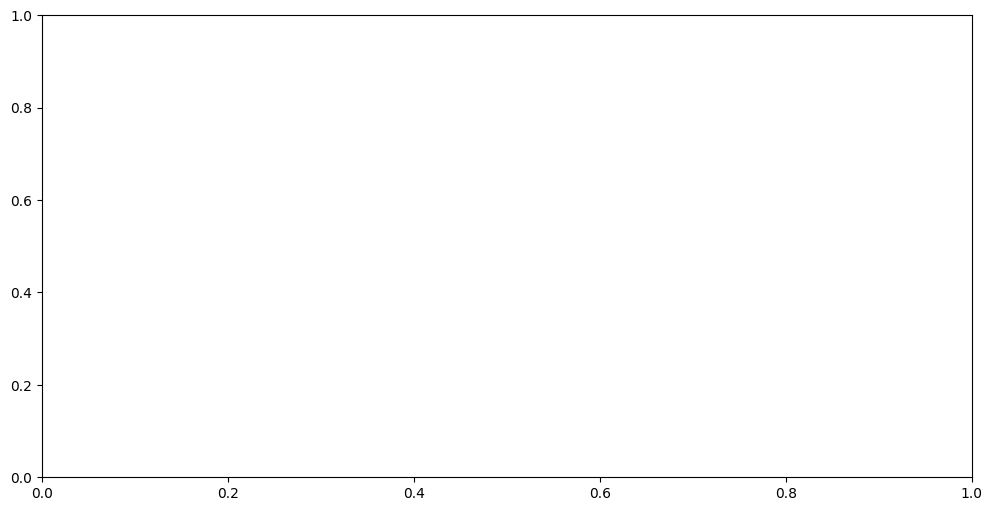

In [13]:
process_data = {
        'Epoch': list(range(1, NUM_EPOCHS + 1)),
        'Train Loss': training_loss,
        'Train Accuracy': training_acc,
        'Test Loss': testing_loss,
        'Test Accuracy': testing_acc,
}
plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Loss'], label='Train Loss', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Loss'], label='Test Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(process_data['Epoch'], process_data['Train Accuracy'], label='Train Accuracy', marker='o')
plt.plot(process_data['Epoch'], process_data['Test Accuracy'], label='Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # 在这里定义 train_and_evaluate 函数，包含你的训练和评估逻辑
    # 返回训练好的模型
    model = models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    return model
if __name__ == '__main__':

    learning_rate = 0.1
    momentum = 0.5
    step = 5
    gamma = 0.9
    EVAL_INTERVAL = 1
    results = []

    SEED = 1
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    result = train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL)


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [67]:
def train_batch(model, image, target):
    # Perform one training batch iteration.
    output = model(image)
    loss_fn = nn.L1Loss()
    loss = loss_fn(output, target)
    return output, loss


def test_batch(model, image, target):
    # Perform one testing batch iteration.
    output = model(image)
    loss_fn = nn.L1Loss()
    loss = loss_fn(output, target)
    return output, loss


def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # Define your model, optimizer, and other necessary components
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    NUM_CLASS = 10
    BATCH_SIZE = 64
    NUM_EPOCHS = 30
    SAVE_DIR = './log'
    transform_cifar10_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_cifar10_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                             download=True, transform=transform_cifar10_train)

    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                                   shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                            download=True, transform=transform_cifar10_test)

    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                                  shuffle=False, num_workers=2)
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    model = models.resnet18(weights='imagenet')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)

    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()
        running_cls_loss = 0.0
        running_cls_corrects = 0

        for batch_idx, (image, target) in enumerate(train_dataloader):
            image = image.to(device)
            target = target.to(device)

            outputs, loss = train_batch(model, image, target)
            _, preds = torch.max(outputs, 1)

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        scheduler.step()

        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch + 1) == NUM_EPOCHS:
            print('Begin test...')
            model.eval()
            val_loss = 0.0
            val_corrects = 0

            for batch_idx, (image, target) in enumerate(test_dataloader):
                image = image.to(device)
                target = target.to(device)

                outputs, loss = test_batch(model, image, target)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

            if (epoch + 1) == NUM_EPOCHS:

                state = {
                    'state_dict': model.state_dict(),
                    'acc': epoch_acc,
                    'epoch': (epoch + 1),
                }

                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch + 1))))

In [68]:
inputs, classes = next(iter(test_dataloader))
inputs = inputs.to(device)
input = inputs[0]
input = input.to(device)

In [69]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
with torch.no_grad():
        model.eval()
        output = model(input.unsqueeze(0))
        probabilities = torch.softmax(output, dim=1)
        predict_label = torch.argmax(probabilities, dim=1).item()
#probabilities = torch.softmax(output, dim=1)
#predict_label = torch.argmax(probabilities, dim=1)

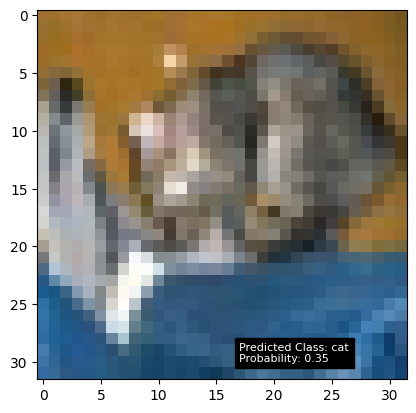

Print probabilities for each class:
airplane: 0.0102
automobile: 0.0299
bird: 0.0211
cat: 0.3547
deer: 0.0321
dog: 0.1728
frog: 0.2945
horse: 0.0359
ship: 0.0270
truck: 0.0217


In [70]:
predicted_class = class_names[predict_label]
predicted_probability = probabilities[0, predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
image = (image * np.array([0.2023, 0.1994, 0.2010])) + np.array([0.4914, 0.4822, 0.4465])
image = np.clip(image, 0, 1)
image = Image.fromarray((image * 255).astype(np.uint8))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0,i].item():.4f}')
def train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL):
    # 在这里定义 train_and_evaluate 函数，包含你的训练和评估逻辑
    # 返回训练好的模型
    model = models.resnet18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, NUM_CLASS)
    
    return model
if __name__ == '__main__':

    learning_rate = 0.1
    momentum = 0.5
    step = 5
    gamma = 0.9
    EVAL_INTERVAL = 30
    results = []

    SEED = 1
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)

    result = train_and_evaluate(learning_rate, momentum, gamma, step, EVAL_INTERVAL)